In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pythae
import pickle
from PIL import Image

In [4]:
from pythae.trainers import BaseTrainerConfig
from pythae.models import VAE, VAEConfig, BetaVAE, BetaVAEConfig
from pythae.pipelines import TrainingPipeline
from pythae.samplers import NormalSampler
from pythae.models.nn.benchmarks.mnist import Encoder_ResNet_VAE_MNIST, Decoder_ResNet_AE_MNIST
import torch
import torch.nn as nn
from pythae.models.nn.base_architectures import BaseDecoder, BaseEncoder
from pythae.models.base.base_config import BaseAEConfig
from pythae.models.nn.benchmarks.utils import ResBlock
from pythae.models.base.base_utils import ModelOutput

In [5]:
latent_dim = 2
epochs = 10
save_location = ""
concept_alignment = False

In [6]:
train_data = pickle.load(open("CUB/preprocessed/train.pkl","rb"))
train_files = [i['img_path'] for i in train_data]
train_images = []
for i in train_files:
    img = Image.open(i)
    img = img.resize((64,64))
    train_images.append(np.array(img)/255)


In [7]:
# Remove black and white images
train_data = [i for _,i in enumerate(train_data) if len(train_images[_].shape) == 3]
train_images = [i for i in train_images if len(i.shape) == 3]
train_concepts = np.array([i['attribute_label'] for i in train_data])

In [8]:
val_data = pickle.load(open("CUB/preprocessed/val.pkl","rb"))
val_files = [i['img_path'] for i in val_data]
val_images = []
for i in val_files:
    img = Image.open(i)
    img = img.resize((64,64))
    val_images.append(np.array(img)/255)
val_concepts = np.array([i['attribute_label'] for i in val_data])

In [9]:
# Remove black and white images
val_data = [i for _,i in enumerate(val_data) if len(val_images[_].shape) == 3]
val_images = [i for i in val_images if len(i.shape) == 3]
val_concepts = np.array([i['attribute_label'] for i in val_data])

In [10]:
test_data = pickle.load(open("CUB/preprocessed/test.pkl","rb"))
test_files = [i['img_path'] for i in test_data]
test_images = []
for i in test_files:
    img = Image.open(i)
    img = img.resize((64,64))
    test_images.append(np.array(img)/255)
test_concepts = np.array([i['attribute_label'] for i in test_data])

In [11]:
# Remove black and white images
test_data = [i for _,i in enumerate(test_data) if len(test_images[_].shape) == 3]
test_images = [i for i in test_images if len(i.shape) == 3]
test_concepts = np.array([i['attribute_label'] for i in test_data])

In [12]:
my_training_config = BaseTrainerConfig(
    output_dir='my_model',
    num_epochs=20,
    learning_rate=1e-3,
    per_device_train_batch_size=200,
    per_device_eval_batch_size=200,
    train_dataloader_num_workers=2,
    eval_dataloader_num_workers=2,
    steps_saving=20,
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 5, "factor": 0.5}, 
)

In [13]:
my_vae_config = model_config = BetaVAEConfig(
input_dim=(64,64,3),
latent_dim=128,
beta=2.
)

In [14]:
class Encoder_ResNet_VAE_CUB(BaseEncoder):
    def __init__(self, args: BaseAEConfig):
        BaseEncoder.__init__(self)

        self.input_dim = (3, 64,64)
        self.latent_dim = args.latent_dim
        self.n_channels = 3

        layers = nn.ModuleList()

        layers.append(nn.Sequential(nn.Conv2d(self.n_channels, 64, 4, 2, padding=1)))

        layers.append(nn.Sequential(nn.Conv2d(64, 128, 4, 2, padding=1)))

        layers.append(nn.Sequential(nn.Conv2d(128, 128, 3, 2, padding=1)))

        layers.append(
            nn.Sequential(
                ResBlock(in_channels=128, out_channels=32),
                ResBlock(in_channels=128, out_channels=32),
            )
        )

        self.layers = layers
        self.depth = len(layers)

        self.embedding = nn.Linear(128 * 4 * 4 *4, args.latent_dim)
        self.log_var = nn.Linear(128 * 4 * 4 *4, args.latent_dim)

    def forward(self, x, output_layer_levels = None):
        output = ModelOutput()

        max_depth = self.depth

        if output_layer_levels is not None:

            assert all(
                self.depth >= levels > 0 or levels == -1
                for levels in output_layer_levels
            ), (
                f"Cannot output layer deeper than depth ({self.depth})."
                f"Got ({output_layer_levels})."
            )

            if -1 in output_layer_levels:
                max_depth = self.depth
            else:
                max_depth = max(output_layer_levels)

        out = x

        for i in range(max_depth):
            out = self.layers[i](out)

            if output_layer_levels is not None:
                if i + 1 in output_layer_levels:
                    output[f"embedding_layer_{i+1}"] = out
            if i + 1 == self.depth:
                output["embedding"] = self.embedding(out.reshape(x.shape[0], -1))
                output["log_covariance"] = self.log_var(out.reshape(x.shape[0], -1))
                
        return output
class Decoder_ResNet_AE_CUB(BaseDecoder):

    def __init__(self, args: BaseAEConfig):
        BaseDecoder.__init__(self)

        self.input_dim = (3,64,64)
        self.latent_dim = args.latent_dim
        self.n_channels = 3

        layers = nn.ModuleList()

        layers.append(nn.Linear(args.latent_dim, 128 * 4 * 4))

        layers.append(nn.ConvTranspose2d(128, 128, 4, 2, padding=1))

        layers.append(
            nn.Sequential(
                ResBlock(in_channels=128, out_channels=32),
                ResBlock(in_channels=128, out_channels=32),
                ResBlock(in_channels=128, out_channels=32),
                nn.ReLU(),
            )
        )

        layers.append(
            nn.Sequential(
                nn.ConvTranspose2d(128, 64, 4, 2, padding=1, output_padding=0),
                nn.ReLU(),
            )
        )

        layers.append(
            nn.Sequential(
                nn.ConvTranspose2d(64, 64, 4, 2, padding=1, output_padding=0),
                nn.ReLU(),
            )
        )

        
        layers.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    64, self.n_channels, 4, 2, padding=1, output_padding=0
                ),
                nn.Sigmoid(),
            )
        )

        self.layers = layers
        self.depth = len(layers)

    def forward(self, z, output_layer_levels = None):
        output = ModelOutput()

        max_depth = self.depth

        if output_layer_levels is not None:

            assert all(
                self.depth >= levels > 0 or levels == -1
                for levels in output_layer_levels
            ), (
                f"Cannot output layer deeper than depth ({self.depth})."
                f"Got ({output_layer_levels})"
            )

            if -1 in output_layer_levels:
                max_depth = self.depth
            else:
                max_depth = max(output_layer_levels)

        out = z
        
        for i in range(max_depth):
            out = self.layers[i](out)

            if i == 0:
                out = out.reshape(z.shape[0], 128, 4, 4)                
            if output_layer_levels is not None:
                if i + 1 in output_layer_levels:
                    output[f"reconstruction_layer_{i+1}"] = out

            if i + 1 == self.depth:
                output["reconstruction"] = out
                
        return output


In [15]:
my_vae_model = BetaVAE(
model_config=my_vae_config,
encoder=Encoder_ResNet_VAE_CUB(my_vae_config), 
decoder=Decoder_ResNet_AE_CUB(my_vae_config) 
)


In [104]:
pipeline = TrainingPipeline(
training_config=my_training_config,
model=my_vae_model
)


In [119]:
train_images_transpose = np.array(train_images).transpose(0, 3, 1, 2)
val_images_transpose = np.array(val_images).transpose(0, 3, 1, 2)
test_images_transpose = np.array(test_images).transpose(0,3,1,2)

In [106]:
pipeline(
    train_data=train_images_transpose,
    eval_data=val_images_transpose
)


Preprocessing train data...
INFO:pythae.pipelines.training:Preprocessing train data...
Checking train dataset...
INFO:pythae.pipelines.training:Checking train dataset...
Preprocessing eval data...

INFO:pythae.pipelines.training:Preprocessing eval data...

Checking eval dataset...
INFO:pythae.pipelines.training:Checking eval dataset...
Using Base Trainer

INFO:pythae.pipelines.training:Using Base Trainer

Model passed sanity check !
Ready for training.

INFO:pythae.trainers.base_trainer.base_trainer:Model passed sanity check !
Ready for training.

Created my_model/BetaVAE_training_2023-03-01_16-31-58. 
Training config, checkpoints and final model will be saved here.

INFO:pythae.trainers.base_trainer.base_trainer:Created my_model/BetaVAE_training_2023-03-01_16-31-58. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 20
 - per_device_train_batch_size: 200
 - per_device_eval_batch_size: 200
 - checkpoint saving every: 20
Optimizer: AdamW (

Training of epoch 1/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 1/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 829.9019
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 829.9019
Eval loss: 609.5538
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 609.5538
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 2/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 2/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 560.867
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 560.867
Eval loss: 481.8396
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 481.8396
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 3/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 3/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 456.2875
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 456.2875
Eval loss: 418.0123
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 418.0123
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 4/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 4/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 415.0519
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 415.0519
Eval loss: 399.8544
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 399.8544
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 5/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 5/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 396.5647
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 396.5647
Eval loss: 383.8853
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 383.8853
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 6/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 6/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 382.9485
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 382.9485
Eval loss: 372.5791
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 372.5791
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 7/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 7/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 370.6096
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 370.6096
Eval loss: 367.5891
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 367.5891
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 8/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 8/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 361.1625
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 361.1625
Eval loss: 349.4479
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 349.4479
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 9/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 9/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 349.4554
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 349.4554
Eval loss: 338.6651
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 338.6651
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 10/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 10/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 334.1166
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 334.1166
Eval loss: 320.1936
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 320.1936
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 11/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 11/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 322.743
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 322.743
Eval loss: 314.8224
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 314.8224
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 12/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 12/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 312.3503
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 312.3503
Eval loss: 307.4445
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 307.4445
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 13/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 13/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 305.8118
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 305.8118
Eval loss: 302.7086
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 302.7086
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 14/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 14/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 302.8049
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 302.8049
Eval loss: 299.5951
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 299.5951
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 15/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 15/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 300.437
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 300.437
Eval loss: 300.7013
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 300.7013
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 16/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 16/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 296.8862
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 296.8862
Eval loss: 293.7413
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 293.7413
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 17/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 17/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 294.3772
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 294.3772
Eval loss: 293.0343
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 293.0343
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 18/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 18/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 293.3051
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 293.3051
Eval loss: 288.401
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 288.401
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 19/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 19/20:   0%|          | 0/6 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 288.9726
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 288.9726
Eval loss: 289.364
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 289.364
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 20/20:   0%|          | 0/24 [00:00<?, ?batch/s]

Eval of epoch 20/20:   0%|          | 0/6 [00:00<?, ?batch/s]

Saved checkpoint at epoch 20

INFO:pythae.trainers.base_trainer.base_trainer:Saved checkpoint at epoch 20

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 288.2436
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 288.2436
Eval loss: 285.5482
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 285.5482
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Training ended!
INFO:pythae.trainers.base_trainer.base_trainer:Training ended!
Saved final model in my_model/BetaVAE_training_2023-03-01_16-31-58/final_model
INFO:pythae.trainers.base_trainer.base_trainer:Saved final model in my_model/BetaVAE_training_2023-03-01_16-31-58/final_model


In [16]:
my_vae_model

BetaVAE(
  (decoder): Decoder_ResNet_AE_CUB(
    (layers): ModuleList(
      (0): Linear(in_features=128, out_features=2048, bias=True)
      (1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (2): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()


In [107]:
my_samper = NormalSampler(
    model=my_vae_model
)

In [108]:
gen_data = my_samper.sample(
    num_samples=10,
    batch_size=10,
    output_dir=None,
    return_gen=True
)


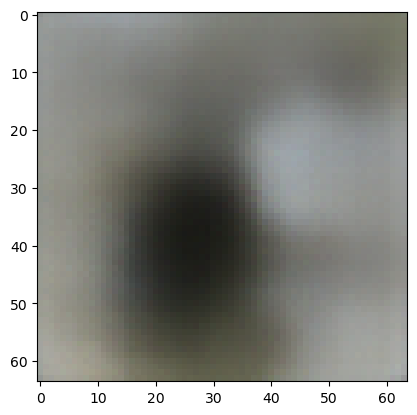

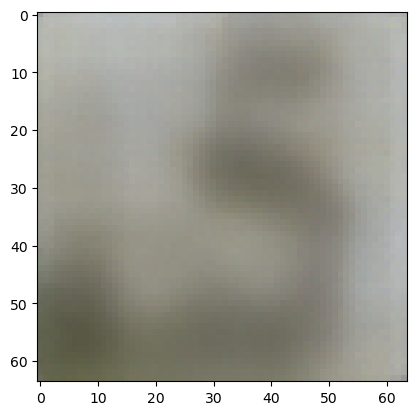

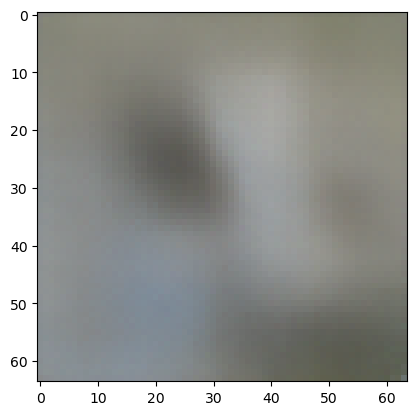

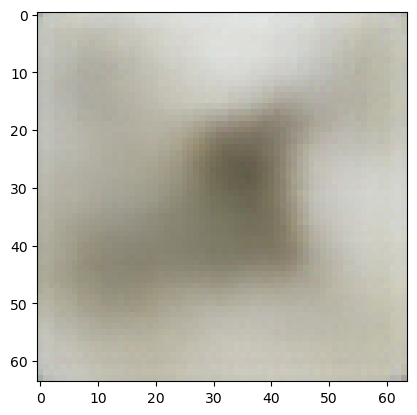

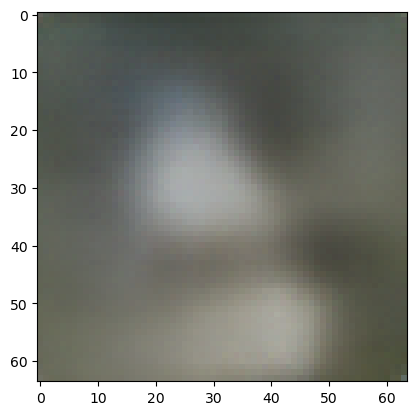

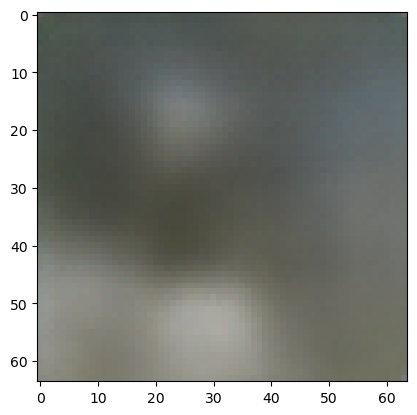

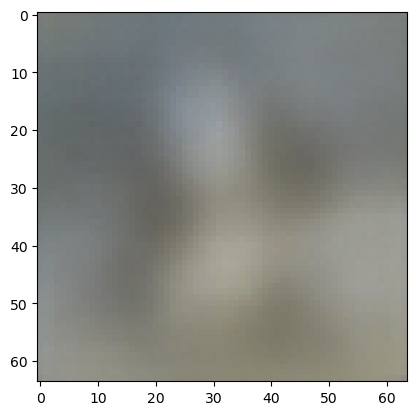

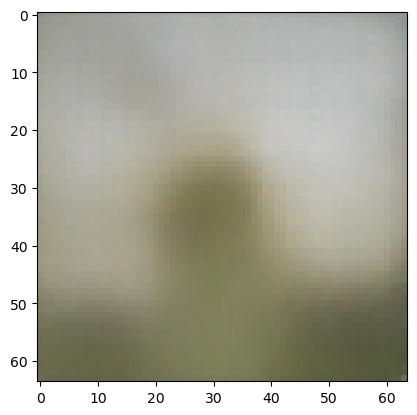

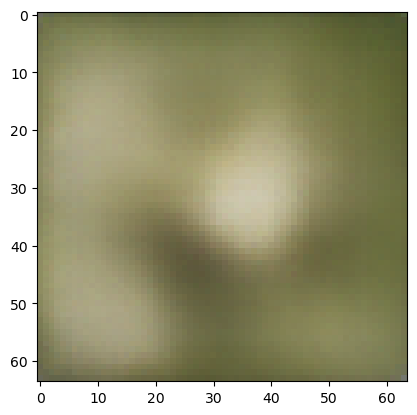

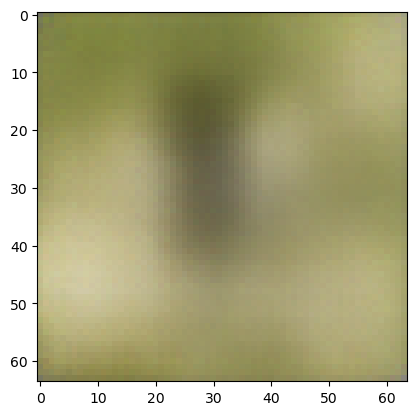

In [109]:
for i in range(len(gen_data)):
    plt.figure()
    plt.imshow(np.array(gen_data[i]).transpose(1,2,0))

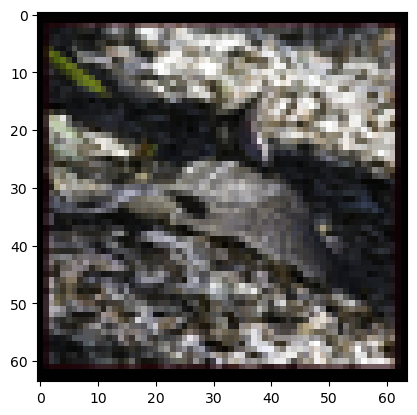

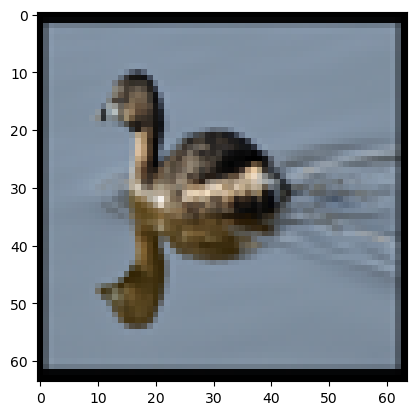

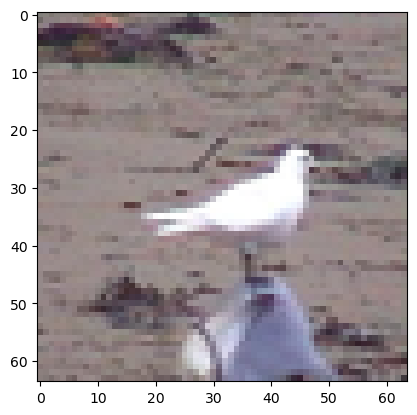

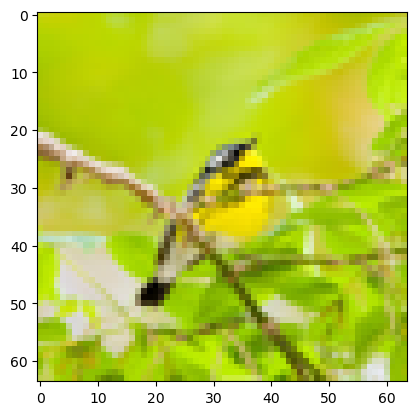

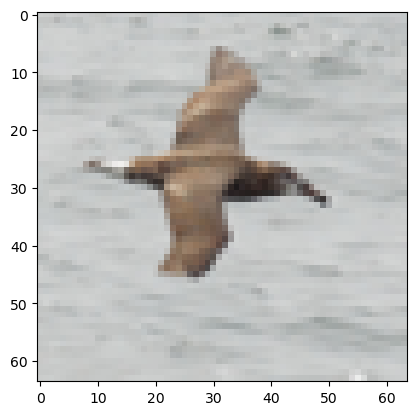

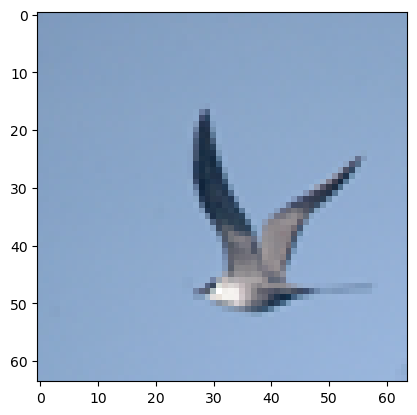

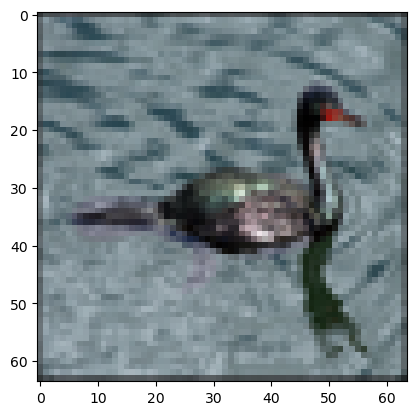

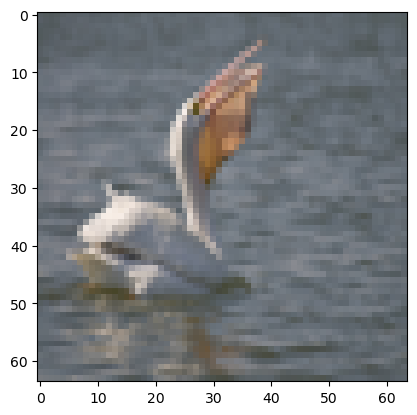

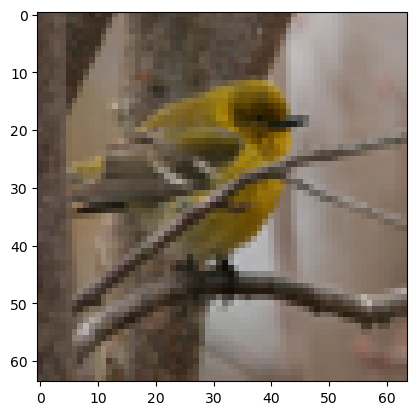

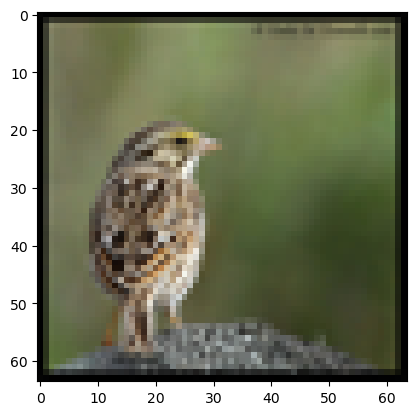

In [110]:
for i in range(len(gen_data)):
    plt.figure()
    plt.imshow(np.array(train_images_transpose[i]).transpose(1,2,0))

In [111]:
output = my_vae_model.encoder(torch.Tensor([train_images_transpose[1]]))

In [112]:
z = output['embedding']

In [113]:
output_to_image = my_vae_model.decoder(z)['reconstruction'][0]

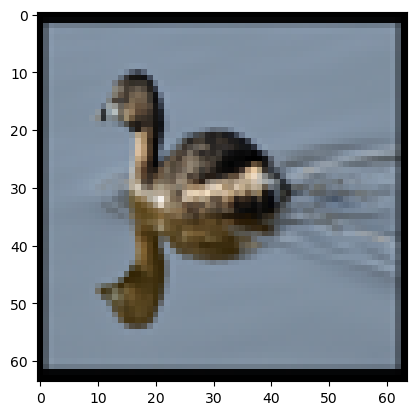

In [114]:
plt.imshow(np.array(train_images_transpose[1]).transpose(1,2,0))

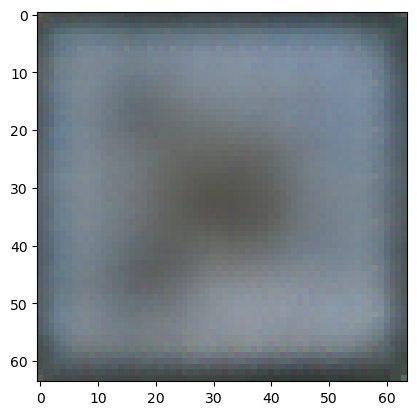

In [116]:
plt.imshow(np.array(output_to_image.detach().numpy()).transpose(1,2,0))

In [126]:
embeddings = my_vae_model.encoder(torch.Tensor(test_images_transpose))['embedding']

In [127]:
embeddings.shape

torch.Size([5790, 128])

In [121]:
attributes = ['has_bill_shape::dagger', 'has_bill_shape::hooked_seabird', 'has_bill_shape::all-purpose', 'has_bill_shape::cone', 'has_wing_color::brown', 'has_wing_color::grey', 'has_wing_color::yellow', 'has_wing_color::black', 'has_wing_color::white', 'has_wing_color::buff', 'has_upperparts_color::brown', 'has_upperparts_color::grey', 'has_upperparts_color::yellow', 'has_upperparts_color::black', 'has_upperparts_color::white', 'has_upperparts_color::buff', 'has_underparts_color::brown', 'has_underparts_color::grey', 'has_underparts_color::yellow', 'has_underparts_color::black', 'has_underparts_color::white', 'has_underparts_color::buff', 'has_breast_pattern::solid', 'has_breast_pattern::striped', 'has_breast_pattern::multi-colored', 'has_back_color::brown', 'has_back_color::grey', 'has_back_color::yellow', 'has_back_color::black', 'has_back_color::white', 'has_back_color::buff', 'has_tail_shape::notched_tail', 'has_upper_tail_color::brown', 'has_upper_tail_color::grey', 'has_upper_tail_color::black', 'has_upper_tail_color::white', 'has_upper_tail_color::buff', 'has_head_pattern::eyebrow', 'has_head_pattern::plain', 'has_breast_color::brown', 'has_breast_color::grey', 'has_breast_color::yellow', 'has_breast_color::black', 'has_breast_color::white', 'has_breast_color::buff', 'has_throat_color::grey', 'has_throat_color::yellow', 'has_throat_color::black', 'has_throat_color::white', 'has_throat_color::buff', 'has_eye_color::black', 'has_bill_length::about_the_same_as_head', 'has_bill_length::shorter_than_head', 'has_forehead_color::blue', 'has_forehead_color::brown', 'has_forehead_color::grey', 'has_forehead_color::yellow', 'has_forehead_color::black', 'has_forehead_color::white', 'has_under_tail_color::brown', 'has_under_tail_color::grey', 'has_under_tail_color::black', 'has_under_tail_color::white', 'has_under_tail_color::buff', 'has_nape_color::brown', 'has_nape_color::grey', 'has_nape_color::yellow', 'has_nape_color::black', 'has_nape_color::white', 'has_nape_color::buff', 'has_belly_color::brown', 'has_belly_color::grey', 'has_belly_color::yellow', 'has_belly_color::black', 'has_belly_color::white', 'has_belly_color::buff', 'has_wing_shape::rounded-wings', 'has_wing_shape::pointed-wings', 'has_size::small_(5_-_9_in)', 'has_size::medium_(9_-_16_in)', 'has_size::very_small_(3_-_5_in)', 'has_shape::duck-like', 'has_shape::perching-like', 'has_back_pattern::solid', 'has_back_pattern::striped', 'has_back_pattern::multi-colored', 'has_tail_pattern::solid', 'has_tail_pattern::striped', 'has_tail_pattern::multi-colored', 'has_belly_pattern::solid', 'has_primary_color::brown', 'has_primary_color::grey', 'has_primary_color::yellow', 'has_primary_color::black', 'has_primary_color::white', 'has_primary_color::buff', 'has_leg_color::grey', 'has_leg_color::black', 'has_leg_color::buff', 'has_bill_color::grey', 'has_bill_color::black', 'has_bill_color::buff', 'has_crown_color::blue', 'has_crown_color::brown', 'has_crown_color::grey', 'has_crown_color::yellow', 'has_crown_color::black', 'has_crown_color::white', 'has_wing_pattern::solid', 'has_wing_pattern::spotted', 'has_wing_pattern::striped', 'has_wing_pattern::multi-colored']

In [133]:
average_embedding_by_concept = {}

for index, name in enumerate(attributes):
    embeddings_with_concept = np.array([embeddings[i].detach().numpy() for i in range(len(test_data)) 
                                        if test_data[i]['attribute_label'][index] == 1])
    mean_embedding = np.mean(embeddings_with_concept,axis=0)
    average_embedding_by_concept[name] = np.array([mean_embedding])


In [134]:

folder_name = "results/vae/cub/42"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)



In [135]:
for concept in average_embedding_by_concept:
    file_name = "{}/{}.npy".format(folder_name,concept)
    np.save(open(file_name,"wb"),average_embedding_by_concept[concept])
